In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install swifter
!pip install git+https://www.github.com/keras-team/keras-contrib.git

%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-qm8hgqm7
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-qm8hgqm7
TensorFlow 1.x selected.
1.15.2


In [3]:
%cd /content/drive/MyDrive/ner-vietnamese/src/LSTM

/content/drive/.shortcut-targets-by-id/1Y4bvRgurskdEet55Gg-Q2Zqg9y7prvJG/ner-vietnamese/src/LSTM


In [4]:
import utils

DATA_PATH = "/content/drive/MyDrive/ner-vietnamese/data-new/dataset"

train =utils.pre_process('train',DATA_PATH)
dev = utils.pre_process('dev',DATA_PATH)
test = utils.pre_process('test',DATA_PATH)

Using TensorFlow backend.


Pandas Apply:   0%|          | 0/626542 [00:00<?, ?it/s]

load train


Pandas Apply:   0%|          | 0/121897 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/255120 [00:00<?, ?it/s]

In [5]:
train

,sentence_id,words,labels
0,0,Bão,O
1,0,Saudel,O
2,0,đổ,O
3,0,bộ,O
4,0,Philippines,B-LOCATION-GPE
...,...,...,...
615540,30084,về,O
615541,30084,những,O
615542,30084,gì,O
615543,30084,mình,O


In [6]:
train['sentence_id'].nunique()

21291

In [7]:
dev['sentence_id'] = dev.apply(lambda row: row.sentence_id + 32000, axis=1)
print(dev['sentence_id'].nunique())

4049


In [8]:
test['sentence_id'] = test.apply(lambda row: row.sentence_id + 40000, axis=1)
print(test['sentence_id'].nunique())

7610


In [9]:
import pandas as pd
all_data = pd.concat([train,dev,test])

In [10]:
X_train, X_test, y_train, y_test, word2idx, tag2idx, idx2word, idx2tag, num_tag,words, tags  = utils.process_data(all_data)

In [11]:
X_train.shape

(26360, 400)

In [12]:
# Config
batch_size = 64
epochs = 20
max_len = 400
embedding = 40

In [13]:
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional
from keras.models import Model, Input, load_model
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint

In [14]:
def build_model(num_tags, hidden_size = 50):
    # Model architecture
    input = Input(shape=(max_len,))
    model = Embedding(input_dim=len(words) + 2, output_dim=embedding, input_length=max_len, mask_zero=False)(input)
    model = Bidirectional(LSTM(units=hidden_size, return_sequences=True, recurrent_dropout=0.1))(model)
    model = TimeDistributed(Dense(hidden_size, activation="relu"))(model)
    crf = CRF(num_tags + 1)  # CRF layer
    out = crf(model)  # output

    model = Model(input, out)
    model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

    model.summary()
    return model

In [15]:
import os 
import numpy as np
MODEL_PATH = "/content/"
# if not os.path.exists(MODEL_PATH + "model.hdf5"):

model = build_model(num_tag)
checkpoint = ModelCheckpoint(filepath = MODEL_PATH +'model.hdf5',
                        verbose = 0,
                        mode = 'auto',
                        save_best_only = True,
                        monitor='val_loss')
history = model.fit(X_train, np.array(y_train), batch_size=batch_size, epochs=epochs,
                    validation_split=0.1, callbacks=[checkpoint])
# else:
#     model = build_model(num_tag)
#     model.load_weights(MODEL_PATH + "model.hdf5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 400, 40)           809520    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 400, 100)          36400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 400, 50)           5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 400, 88)           12408     
Total params: 863,378
Trainable params: 863,378
Non-trainable params: 0
_________________________________________________________________

Train on 23724 samples, 

KeyboardInterrupt: ignored

In [16]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y_test, -1)

In [17]:
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true]

In [18]:
flat_true =[]
flat_pred =[]
for sent in y_test_true:
  for x in sent:
    flat_true.append(x)

for sent in y_pred:
  for x in sent:
    flat_pred.append(x)

2636000
2636000


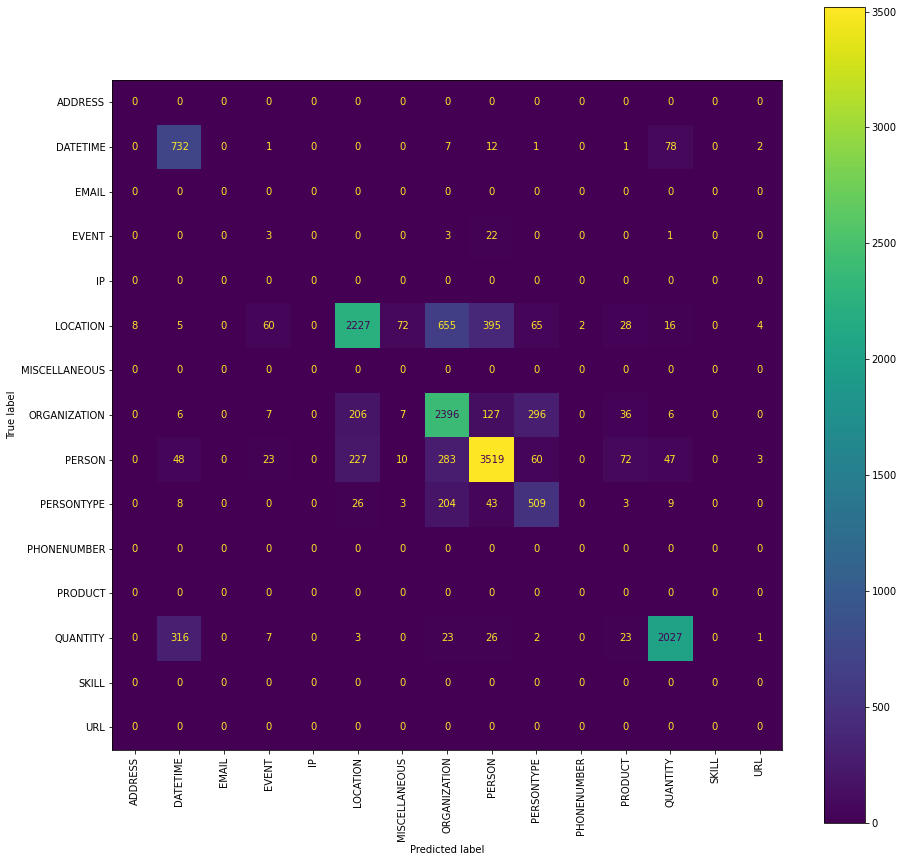

In [19]:
labels = utils.get_list_tag()

flat_true_coff = []
flat_preds_coff = []

for sent in y_test_true:
  for x in sent:
    if '-' in x:
        x = x.split('-')[1]
    flat_true_coff.append(x) 

for sent in y_pred:
  for x in sent:
    if '-' in x:
        x = x.split('-')[1]
    flat_preds_coff.append(x) 

print(len(flat_preds_coff))
print(len(flat_true_coff))

label_rm_begin = []
for x in labels:
    if '-' in x:
        x = x.split('-')[1]
    label_rm_begin.append(x)


label_rm_begin = list(set(label_rm_begin))

label_rm_begin.sort()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


cm = confusion_matrix(flat_preds_coff, flat_true_coff, labels=label_rm_begin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_rm_begin)
fig, ax = plt.subplots(figsize=(15,15))

disp.plot(ax=ax)
plt.xticks(rotation = 90)
plt.show()  

In [20]:
import sklearn

In [21]:
labels.sort()

In [22]:
print(sklearn.metrics.classification_report(
    flat_true, flat_pred, labels=labels, digits=3
))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

                       precision    recall  f1-score   support

            B-ADDRESS      0.000     0.000     0.000         2
           B-DATETIME      0.736     0.271     0.396       990
      B-DATETIME-DATE      0.222     0.011     0.020       190
 B-DATETIME-DATERANGE      0.000     0.000     0.000        69
  B-DATETIME-DURATION      0.667     0.075     0.135       267
       B-DATETIME-SET      0.000     0.000     0.000         0
      B-DATETIME-TIME      0.000     0.000     0.000        22
 B-DATETIME-TIMERANGE      0.000     0.000     0.000        55
              B-EMAIL      0.000     0.000     0.000         1
              B-EVENT      0.000     0.000     0.000        35
          B-EVENT-CUL      0.000     0.000     0.000        40
     B-EVENT-GAMESHOW      0.000     0.000     0.000        36
      B-EVENT-NATURAL      0.000     0.000     0.000         0
        B-EVENT-SPORT      0.000     0.000     0.000        39
                 B-IP      0.000     0.000     0.000  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
